In [2]:
import pandas as pd
import pickle
import numpy as np

# 1. 加载pickle文件，获取字典
file_path = './data/GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# 2. 创建一个新的字典，所有键都转换为小写，以实现不区分大小写的匹配
data_lower = {key.lower(): value for key, value in data.items()}

# 提取字典中的所有键并转换为小写
dict_keys = list(data_lower.keys())

# 3. 加载CSV文件的第9列到倒数第四列（索引从0开始）
csv_file_path = './data/countsphe2.csv'
df = pd.read_csv(csv_file_path)

# 获取CSV文件第9列到倒数第四列的列名，并转换为小写
csv_column_names = df.columns[8:-3].str.lower()  # 从第9列开始到倒数第四列

# 打印所有列名
print("Columns in the CSV (from 9th to fourth last):")
print(csv_column_names)

# 4. 检查这些列名是否存在于字典的键中，并打印不存在的列名
missing_columns = [col for col in csv_column_names if col not in dict_keys]

if missing_columns:
    print("\nColumns that are missing from the dictionary keys:")
    print(missing_columns)
else:
    print("\nAll CSV columns are found in the dictionary keys.")

# 5. 删除不匹配的列
# 先获取需要保留的列
columns_to_keep = [col for col in csv_column_names if col in dict_keys]

# 删除那些不在字典中的列
# 这里所有列名已经转换为小写，以便进行比较
df_cleaned = df.drop(columns=[col for col in df.columns[8:-3] if col.lower() not in columns_to_keep])

# 6. 检查并删除全零行
# 获取保留的基因列名
gene_columns = df_cleaned.columns[8:-3]

# 检查每一行是否所有基因表达量都为零
rows_all_zero = (df_cleaned[gene_columns] == 0).all(axis=1)
# 检查每一行是否有NaN值
rows_with_na = df_cleaned[gene_columns].isna().any(axis=1)

# 合并条件：删除全零行或包含NaN的行
rows_to_remove = rows_all_zero | rows_with_na
num_rows_to_remove = rows_to_remove.sum()

if num_rows_to_remove > 0:
    df_cleaned = df_cleaned[~rows_to_remove]
    print(f"Removed {num_rows_to_remove} rows with all gene expressions equal to zero or containing NaN values.")
else:
    print("No rows with all gene expressions equal to zero or containing NaN values were found.")

# 7. 将基因列名转换为小写，以避免后续访问时的KeyError
# 仅转换基因列（第9列到倒数第四列）为小写
new_gene_columns = gene_columns.str.lower()
new_columns = list(df_cleaned.columns[:8]) + list(new_gene_columns) + list(df_cleaned.columns[-3:])
df_cleaned.columns = new_columns

output_file_path = './data/cleaned_countsnormal.csv'
# 打印统计信息
total_genes = len(csv_column_names)
missing_genes = len(missing_columns)
print("\nTotal number of gene names:", total_genes)
print("Number of gene names missing in the dictionary:", missing_genes)
# 保存清理后的 CSV 文件
df_cleaned.to_csv(output_file_path, index=False)
print(f"Cleaned data has been saved to: {output_file_path}")


# 8. 打开保存的 cleaned_countsnormal2.csv 文件并进行加权基因表达计算
# 加载清理后的CSV文件
df_processed = pd.read_csv(output_file_path)


# 选择第9列到倒数第四列，并转换为小写
gene_columns_processed = df_processed.columns[8:-3].str.lower()

# 初始化一个列表来存储每个细胞的加权基因表达矩阵
cell_weighted_expressions = []

# 获取所有基因的嵌入矩阵，并存储在字典中以提高效率
# 假设所有嵌入矩阵的形状相同
embedding_shape = None
embeddings = {}
for gene in gene_columns_processed:
    embedding = data_lower.get(gene)  # 使用小写基因名进行查找
    if embedding is not None:
        embeddings[gene] = embedding
        if embedding_shape is None:
            embedding_shape = np.array(embedding).shape
    else:
        print(f"Warning: Gene '{gene}' not found in the dictionary.")

# 检查是否找到了至少一个基因的嵌入
if not embeddings:
    raise ValueError("No gene embeddings found. Cannot proceed with weighted expression calculation.")

# 转换嵌入为numpy数组以提高计算效率
for gene in embeddings:
    embeddings[gene] = np.array(embeddings[gene])

# 遍历每一行（细胞）进行加权计算
for index, row in df_processed.iterrows():
    # 初始化加权基因表达矩阵为零矩阵
    weighted_expression = np.zeros(embedding_shape)
    
    # 遍历所有基因并进行加权
    for gene in gene_columns_processed:
        expr_value = row[gene]
        embedding = embeddings.get(gene)
        if embedding is not None:
            weighted_expression += expr_value * embedding
    
    # 将结果添加到列表中
    cell_weighted_expressions.append(weighted_expression)

    # 可选：打印进度
    if (index + 1) % 1000 == 0:
        print(f"Processed {index + 1} cells.")

# 9. 保存加权基因表达结果
# 将列表转换为numpy数组，形状为 (细胞数, 嵌入矩阵维度...)
cell_weighted_expressions = np.array(cell_weighted_expressions)

# 保存为pickle文件
result_pickle_path = './data/cell_weighted_gene_expression.pkl'
with open(result_pickle_path, 'wb') as f:
    pickle.dump(cell_weighted_expressions, f)

print(f"Weighted gene expressions for all cells have been saved to: {result_pickle_path}")

# 将加权表达结果保存为CSV文件
# 创建列名，例如 dim_1, dim_2, ..., dim_n
embedding_dim = cell_weighted_expressions.shape[1]
weighted_columns = [f"dim_{i+1}" for i in range(embedding_dim)]

# 创建DataFrame
weighted_df = pd.DataFrame(cell_weighted_expressions, columns=weighted_columns)

# 如果需要保留原始细胞信息，可以将其添加到weighted_df中
# 假设前8列是细胞信息
x_column = 'x'
y_column = 'y'
# 提取x和y列信息
x_info = df_processed[x_column].reset_index(drop=True)
y_info = df_processed[y_column].reset_index(drop=True)

cell_info = df_processed.iloc[:, :8].reset_index(drop=True)
weighted_df = pd.concat([cell_info, x_info, y_info, weighted_df], axis=1)

# 保存为CSV文件
weighted_csv_path = './data/cell_weighted_gene_expression.csv'
weighted_df.to_csv(weighted_csv_path, index=False)
print(f"Weighted gene expressions for all cells have been saved to: {weighted_csv_path}")


Columns in the CSV (from 9th to fourth last):
Index(['aadat', 'abca13', 'abcb11', 'acan', 'ace2', 'ackr3', 'actl6b', 'actn3',
       'ager', 'aif1l',
       ...
       'uox', 'upk1a', 'upk1b', 'upk3a', 'upk3b', 'vsnl1', 'vsx2', 'vwf',
       'wif1', 'wnt3'],
      dtype='object', length=372)

Columns that are missing from the dictionary keys:
['calm4', 'calm5', 'ccl12', 'ccl9', 'clec4a3', 'cox8b', 'cstdc4', 'ctla2a', 'dbpht2', 'dcpp2', 'des', 'fam183b', 'fcnb', 'gm13889', 'gm94', 'hsd3b4', 'ifitm6', 'klra8', 'kng2', 'lce1m', 'mettl7a2', 'mrgpra2a', 'ms4a6b', 'ms4a6c', 'retnla', 'serpina3n', 'stfa2l1', 'try10', 'uox']
Removed 173 rows with all gene expressions equal to zero or containing NaN values.

Total number of gene names: 372
Number of gene names missing in the dictionary: 29
Cleaned data has been saved to: ./data/cleaned_countsnormal.csv
Processed 1000 cells.
Weighted gene expressions for all cells have been saved to: ./data/cell_weighted_gene_expression.pkl
Weighted gene express

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import kneighbors_graph
import igraph as ig
import leidenalg as la
import umap
import matplotlib.pyplot as plt

# 设定文件路径
weighted_csv_path = './data/cell_weighted_gene_expression.csv'
clustered_csv_path = './data/cell_weighted_gene_expression_with_clusters.csv'
umap_plot_path = './data/cell_weighted_gene_expression_umap.pdf'

# 1. 加载加权基因表达的 CSV 文件
try:
    df_weighted = pd.read_csv(weighted_csv_path)
    print("成功加载加权基因表达的 CSV 文件。")
except FileNotFoundError:
    print(f"错误：找不到文件 {weighted_csv_path}。")
    exit(1)

# 2. 分离细胞元数据和加权基因表达数据
# 假设前8列是细胞元数据，后续列是加权基因表达
cell_metadata = df_weighted.iloc[:, :10]
weighted_expression = df_weighted.iloc[:, 10:]

# 3. 构建 k-最近邻图
# 这里选择 k=15，根据需要调整
k = 15
print("正在构建 k-最近邻图...")
knn_graph = kneighbors_graph(weighted_expression, n_neighbors=k, mode='connectivity', include_self=False)

# 4. 将稀疏矩阵转换为 igraph 图
print("正在将 k-最近邻图转换为 igraph 图...")
# 由于 kneighbors_graph 返回的是一个稀疏矩阵，我们需要确保图是对称的（无向图）
# 通过取最大值来实现对称
knn_graph = knn_graph.maximum(knn_graph.transpose())

# 获取非零元素的行和列索引
edges = np.array(knn_graph.nonzero()).T.tolist()

# 创建 igraph 图
graph = ig.Graph(edges=edges, directed=False)

# 移除自环和多重边
graph.simplify(multiple=True, loops=True)

# 5. 运行 Leiden 聚类
print("正在运行 Leiden 聚类算法...")
partition_type = la.RBConfigurationVertexPartition  # 聚类算法类型
resolution_parameter = 0.13 # Leiden算法的分辨率参数，调整聚类的紧密度
partition = la.find_partition(graph, partition_type, resolution_parameter=resolution_parameter)

# 获取聚类结果
clusters = partition.membership
print(f"共检测到 {len(set(clusters))} 个聚类。")

# 6. 将聚类结果添加到 DataFrame 中
df_weighted['leiden_cluster'] = clusters

# 7. 保存带有聚类结果的 CSV 文件
df_weighted.to_csv(clustered_csv_path, index=False)
print(f"带有聚类结果的 CSV 文件已保存到：{clustered_csv_path}")

clusters_str = [f"cluster {i}" for i in clusters]
df_cleaned111 = pd.read_csv('./data/cleaned_countsnormal.csv')
df_cleaned111['Cluster'] = clusters_str
df_cleaned111.to_csv('./data/ori_gene_cell_type.csv', index=False)
print("带有聚类结果的 CSV 文件已保存为：ori_gene_cell_type.csv")


# 8. 使用 UMAP 进行降维
print("正在进行 UMAP 降维...")
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42,min_dist=0.5, spread=1)
umap_embedding = umap_reducer.fit_transform(weighted_expression)

# 将 UMAP 结果添加到 DataFrame
df_weighted['umap_1'] = umap_embedding[:, 0]
df_weighted['umap_2'] = umap_embedding[:, 1]

# 9. 可视化聚类结果
print("正在生成 UMAP 可视化图...")
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    df_weighted['umap_1'],
    df_weighted['umap_2'],
    c=df_weighted['leiden_cluster'],
    cmap='viridis',
    s=10,
    alpha=0.7
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Leiden Clustering on Weighted Gene Expression (UMAP Projection)')
plt.colorbar(scatter, label='Leiden Cluster')
plt.tight_layout()
plt.savefig(umap_plot_path, dpi=300)
plt.show()
print(f"UMAP 可视化图已保存到：{umap_plot_path}")


C:\Users\25569\anaconda3\envs\genept\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


正在生成 x-y 聚类可视化图...


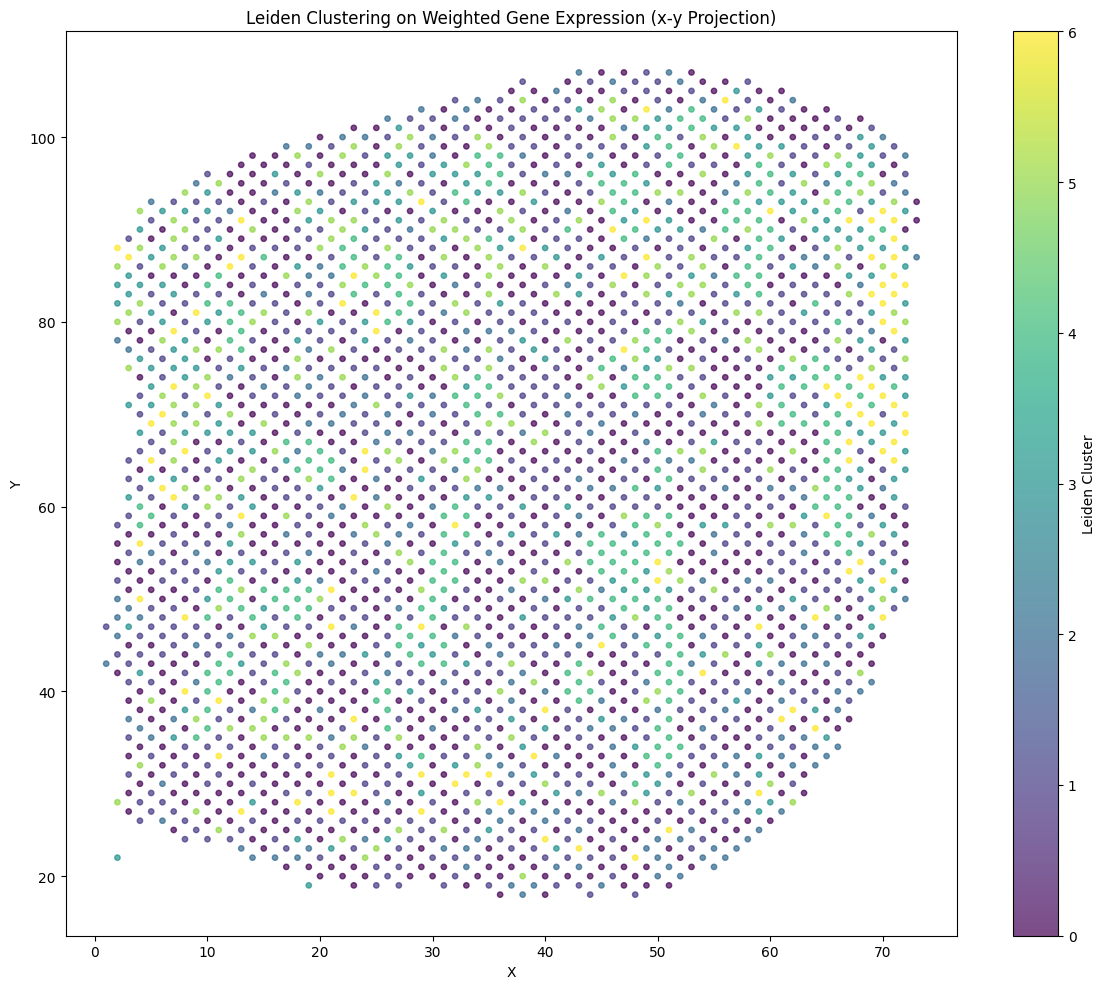

x-y 聚类可视化图已保存到：./data/cell_weighted_gene_expression_x_y.png


In [26]:
# 10. 根据 x 和 y 列进行聚类可视化
xy_plot_path = './data/cell_weighted_gene_expression_x_y.png'  # 新增保存x-y可视化图的路径
x_column = 'x'
y_column = 'y'

print("正在生成 x-y 聚类可视化图...")
plt.figure(figsize=(12, 10))
scatter_xy = plt.scatter(
    df_weighted[x_column],
    df_weighted[y_column],
    c=df_weighted['leiden_cluster'],
    cmap='viridis',
    s=15,
    alpha=0.7
)
plt.xlabel(x_column.capitalize())
plt.ylabel(y_column.capitalize())
plt.title('Leiden Clustering on Weighted Gene Expression (x-y Projection)')
plt.colorbar(scatter_xy, label='Leiden Cluster')
plt.tight_layout()
plt.savefig(xy_plot_path, dpi=300)
plt.show()
print(f"x-y 聚类可视化图已保存到：{xy_plot_path}")